# Goal

A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important data scientist responsibility. Especially, data scientists have to make sure that results are reliable, trustworthy and conclusions can be drawn.

Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually analyzing all of them would require lot of time and people. Therefore, it is common practice to look at the typical A/B test analysis steps and try to automate as much as possible. This frees up time for the data scientist to work on more high level topics.

In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to design an algorithm to automate some steps.

# Challenge Description
Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. Therefore, they agreed to try a test where each country would have its own translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users written by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised because the test is negative. That is, it appears that the non-highly localized translation was doing better!

You are asked to:

- Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better

- Explain why that might be happening. Are the localized translations really worse?

- If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and results can be trusted.


# Data

We have two tables 

The 2 tables are:

- test_table - general information about the test results

    - Columns:

    - user_id: the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.
    - date : when they came to the site for the first time since the test started
    - source : marketing channel: Ads, SEO, Direct. Direct means everything except for ads and SEO, such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
    - device : device used by the user. It can be mobile or web
    - browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish)
    - ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn’t come via an ad, this field is NA
    - browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
    - conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
    - test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.


- user_table - some information about the user

    - Columns:

    - user_id : the id of the user. It can be joined to user id in the other table
    - sex : user sex: Male or Female
    - age : user age (self-reported)
    - country : user country based on ip address


# Solution

A crucial assumption behind an A/B test is that the only difference between test and control has to be the feature we are testing. This implies that test and control user distributions are comparable. If this is true, we can then exactly estimate the impact of the feature change on whichever metric we are testing.


Comparable test and control user distribution means that, for each relevant segment, the relative proportion of users in test and control is similar. That is, if US users are 10% of users in the test group, we expect to also have ~10% of US users in control. If we have 50% of repeat users in test, we should have a similar percentage in control, and so on.

From a purely statistical standpoint, the above should be true over a large enough number of users. And in A/B testing, we are looking for very small gains, so sample size is large, and, therefore, test and control distributions should be the same.


In practice, it is pretty frequent that test and control distributions are different, invalidating the test results. The number one reason for that is bugs or bias in the randomization algorithm that assigns users to test and control, leading to over/under representation of certain segments. That is, we might have more US users in control, but those users have higher conversion rate, so the difference we see in the metric is not only affected by the feature change that we are testing.


It is therefore extremely important to check that test and control distributions are similar before doing the statistical test. Let’s see how.



# Data

In [1]:
import pandas

In [2]:
user = pandas.read_csv("user_table.csv")
test = pandas.read_csv("test_table.csv")

In [8]:
user

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain
...,...,...,...,...
452862,756215,F,27,Venezuela
452863,36888,M,18,Argentina
452864,800559,M,28,Bolivia
452865,176584,M,19,Chile


In [9]:
test

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1
...,...,...,...,...,...,...,...,...,...
453316,425010,2015-12-04,SEO,Web,ES,NaN,FireFox,0,0
453317,826793,2015-12-01,SEO,Mobile,ES,NaN,Android_App,0,1
453318,514870,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0
453319,785224,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,1


In [6]:
print(user.shape)

(452867, 4)


In [7]:
print(test.shape)

(453321, 9)


In [3]:
#let's check that data makes sense
  
print(test['user_id'].nunique()==len(test['user_id']))

True


In [4]:
print(user['user_id'].nunique()==len(user['user_id']))

True


In [5]:
print(len(user['user_id']) - len(test['user_id']))

-454


Looks like the user table is busted and we have some user ids missing. It is so few values that we can safely get rid of those with an inner join. Nothing will change. However, separately, we should still try to find out why that happened. There might be some bug somewhere.

In [10]:
# join
data = test.merge(user, on=['user_id'])
  
#make it a date
data["date"]   = pandas.to_datetime(data["date"])
print(data.describe(include="all"))


<ipython-input-10-7ea9a0d38930>:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(data.describe(include="all"))


               user_id                 date  source  device browser_language  \
count    452867.000000               452867  452867  452867           452867   
unique             NaN                    5       3       2                3   
top                NaN  2015-12-04 00:00:00     Ads     Web               ES   
freq               NaN               141024  181693  251316           377160   
first              NaN  2015-11-30 00:00:00     NaN     NaN              NaN   
last               NaN  2015-12-04 00:00:00     NaN     NaN              NaN   
mean     499944.805166                  NaN     NaN     NaN              NaN   
std      288676.264784                  NaN     NaN     NaN              NaN   
min           1.000000                  NaN     NaN     NaN              NaN   
25%      249819.000000                  NaN     NaN     NaN              NaN   
50%      500019.000000                  NaN     NaN     NaN              NaN   
75%      749543.000000                  

First question is about checking the test results. But even before that, let’s make sure it is true Spain converts much better than LatAm countries.



In [11]:
country_conversion = data.query('test == 0').groupby('country')['conversion'].mean()
  
print(country_conversion.sort_values(ascending=False))


country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64


Yes. Definitely true.

In [12]:
#a simple t-test here should work. We have collected ~0.5MM data and test/control split is ~50/50.
from scipy import stats
  
#nothing changed in Spain, so no point in keeping those users
data = data.query('country != "Spain"') 
  
#t-test of test vs control for our target metric 
test = stats.ttest_ind(data[data['test'] == 1]['conversion'], 
                       data[data['test'] == 0]['conversion'], 
                       equal_var=False
                       )
  
print(data.groupby('test')['conversion'].mean())
  

test
0    0.048292
1    0.043411
Name: conversion, dtype: float64


In [13]:
print(test.statistic)

-7.353895203080277


In [14]:
print(test.pvalue)

1.9289178577799033e-13


Mmh…control users are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are:
- 1) We didn’t collect enough data

- 2) Some bias has been introduced in the experiment so that test/control people are not really random


In data science, whenever results appear too bad or too good to be true, they are not true.

Firstly, let’s plot day by day, to see if these weird results have been constantly happening or they just started happening all of a sudden.

In [17]:
import matplotlib.pyplot as plt

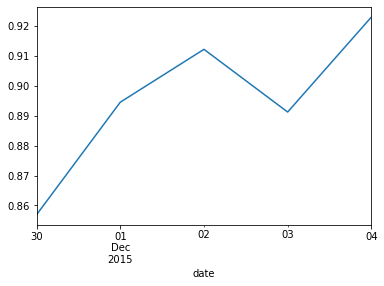

In [23]:
#compare test and control conversion rate by day and plot it
data_test_by_day = data.groupby("date")["conversion"].agg( lambda x: x[data["test"]==1].mean()/x[data["test"]==0].mean()).plot()


From the plot, we notice a couple of things:
- 1.Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up


- 2.As a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better




Time to find out the bias! Likely, there is some segment of users more likely to end up in test or in control. This segment had a significantly above/below conversion rate and this affected the overall results.



# Check A/B Test Randomization

Checking that randomization worked well simply means making sure that all variables have the same distribution in test and control. So, taking for instance the first variable, source, it would mean checking that proportion of users coming from ads, SEO, and direct is the same.


This can easily be done the following way:


In [30]:
#let's group by source and estimate relative frequencies
data_grouped_source = data.groupby("source")["test"].agg({ lambda x: len(x[x==0]),  lambda x: len(x[x==1])}).rename(columns={'<lambda_0>': "frequency_test_0",'<lambda_1>': "frequency_test_1" })
    
#get relative frequencies

In [32]:
data_grouped_source

,frequency_test_0,frequency_test_1
source,,
Ads,74352,86448
Direct,37238,43047
SEO,73721,86279


In [33]:
print(data_grouped_source/data_grouped_source.sum())

        frequency_test_0  frequency_test_1
source                                    
Ads             0.401228          0.400641
Direct          0.200949          0.199500
SEO             0.397823          0.399858


As we can see, relative frequency of source for different segments is the same. That is, we have basically the same proportion of users coming from Ads, Direct, and SEO in both test and control.


We could potentially keep checking all the variables like this. But it would be extremely time consuming (and boring), especially when you start considering numerical variables and categorical variables with many levels.


So we turn this into a machine learning problem and let an algorithm do the boring work for us. The approach is:

- Get rid of the conversion variable for now. We don’t care about it here. We are just checking if the two user distributions are the same. This is before we check conversion rate for the groups


- Use the variable test as our label. Try to build a model that manages to separate the users whose test value is 0 vs those whose test value is 1. If randomization worked well, this will be impossible because the two groups are exactly the same. If all variable relative frequencies were the same as for source, no model would be able to separate test == 1 vs test == 0. If randomization did not work well, the model will manage to use a given variable to separate the two groups.


- As a model, pick a decision tree. This will allow you to clearly see which variable (if any) is used for the split. That’s where randomization failed.


In [35]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import tree  
#make date as string, so few dates that makes sense to have them as few dummy values  
data['date'] = data['date'].apply(str)
  
#make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization
data_dummy = pandas.get_dummies(data)
#model features, test is the label and conversion is not needed 
train_cols = data_dummy.drop(['test', 'conversion'], axis=1)
  
dt=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to understand the tree output
    class_weight="balanced",
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
dt.fit(train_cols,data_dummy['test'])
  
#export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
#s = Source.from_file("tree_test.dot")
#s.view()

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

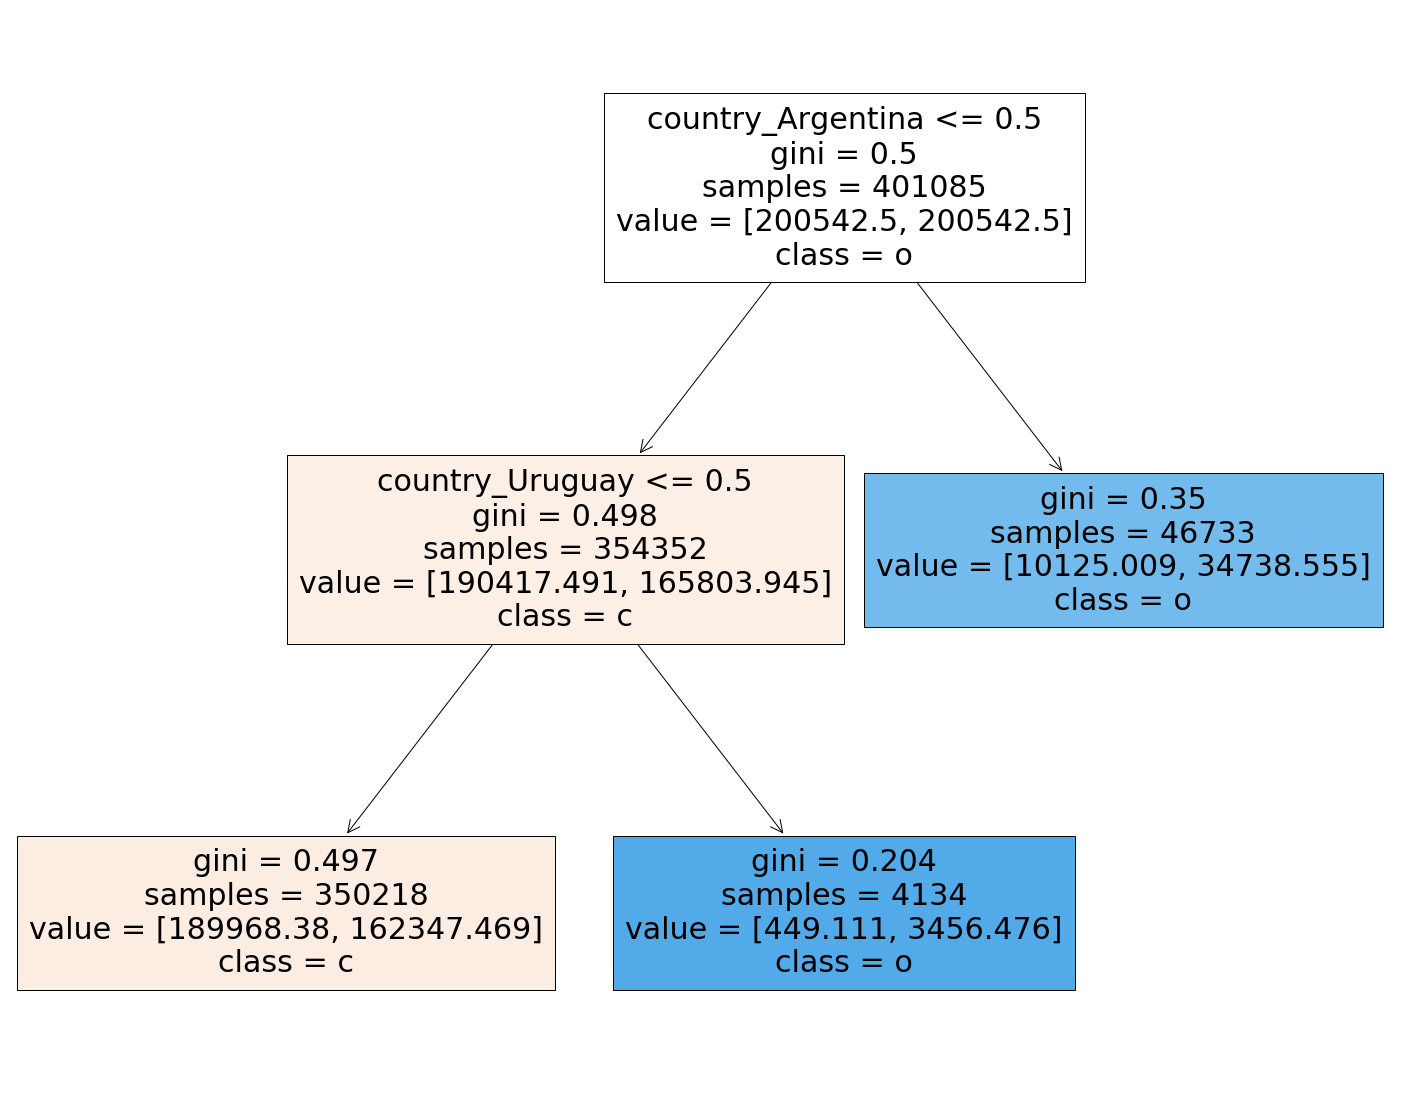

In [37]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=train_cols.columns,  
                   class_names='converted',
                   filled=True)

So we can see that test and control are not the same! Users from Argentina and Uruguay are way more likely to be in test than control. When country_Argentina is 1, the tree shows that users in control are ~23% and in test 77%. For Uruguay, the proportions are even more extreme: 11% in control and 89% in test! Not good!


Let’s double check this. Let’s check proportion of Argentinian and Uruguayan users in control vs test.


In [38]:
print(data_dummy.groupby("test")[["country_Argentina", "country_Uruguay"]].mean())

      country_Argentina  country_Uruguay
test                                    
0              0.050488         0.002239
1              0.173223         0.017236


Our tree was right! In test, 17% of users are from Argentina, but in control only 5% of users are from Argentina. Uruguay is even more extreme: test has 1.7% of users from Uruguay and control has just 0.2% of Uruguayan users.


And this is a big problem because that means we are not comparing anymore apples to apples in our A/B test. The difference we might see in conversion rate might very well depend on the fact that users between the two groups are different.


Let’s check it in practice:

In [39]:
#this is the test results using the orginal dataset
original_data = stats.ttest_ind(data_dummy[data['test'] == 1]['conversion'], 
                                data_dummy[data['test'] == 0]['conversion'], 
                                equal_var=False)
  
#this is after removing Argentina and Uruguay
data_no_AR_UR = stats.ttest_ind(data_dummy[(data['test'] == 1) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                data_dummy[(data['test'] == 0) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                equal_var=False)
  
print(
pandas.DataFrame({"data_type" : ["Full", "Removed_Argentina_Uruguay"], 
                  "p_value" : [original_data.pvalue, data_no_AR_UR.pvalue],
                  "t_statistic" : [original_data.statistic, data_no_AR_UR.statistic]
                 })
)

                   data_type       p_value  t_statistic
0                       Full  1.928918e-13    -7.353895
1  Removed_Argentina_Uruguay  7.200849e-01     0.358346


Huge difference! The biased test where some countries are over/under represented is statistically significant with negative t statistics. So test is worse than control! After removing those two countries, we get non-significant results.

We can also get to the same conclusion by checking how each country is doing taken by itself:

In [41]:
data_test_country = data.groupby('country')['conversion'].agg({
    lambda x: stats.ttest_ind(x[data["test"]==1], 
                              x[data["test"]==0], 
                              equal_var=False).pvalue,
    lambda x: x[data["test"]==1].mean(),
    lambda x: x[data["test"]==0].mean()}).rename(columns={'<lambda_0>': 'p_value','<lambda_1>': 'conversion_test','<lambda_2>': 'conversion_control'}).reindex(['p_value','conversion_test','conversion_control'], 
                                   axis=1
                                 )
                     

In [42]:
print(data_test_country.sort_values(by=['p_value']))

              p_value  conversion_test  conversion_control
country                                                   
Uruguay      0.012048         0.879764            0.012907
Argentina    0.015071         0.335147            0.013725
Panama       0.046796         0.705327            0.049370
Chile        0.048107         0.302848            0.051295
Paraguay     0.048493         0.883697            0.049229
Ecuador      0.049154         0.961512            0.048988
Bolivia      0.049369         0.718885            0.047901
Mexico       0.049495         0.165544            0.051186
Peru         0.049914         0.771953            0.050604
Venezuela    0.050344         0.573702            0.048978
Guatemala    0.050643         0.572107            0.048647
Honduras     0.050906         0.471463            0.047540
Colombia     0.052089         0.423719            0.050571
Costa Rica   0.052256         0.687876            0.054738
Nicaragua    0.052647         0.780400            0.0541

After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!


At this point, you have two options:


Acknowledge that there was a bug, go talk to the software engineer in charge of randomization, figure out what went wrong, fix it and re-run the test. Note that when you find a bug, it might be a sign that more things are messed up, not just the one you found. So when you find a bug, always try to get to the bottom of it


If you do find out that everything else was fine, but for some reason there was only a problem with those two countries, you can potentially adjust the weights for those two segments so that relative frequencies become the same and then re-check the test results

